In [5]:
# Importación de paquetes
import numpy as np # Cálculo numérico
import pandas as pd # Análisis de datos
import matplotlib.pyplot as plt # Visualización

In [6]:
# Creación de la tabla para registrar las réplicas
replicas = pd.DataFrame()

### Parámetros del Modelo

In [27]:
# Condiciones Iniciales
F = 5000 # Costo fijo de producción para Q <= 10.000
V = 3 # Costo variable unitario
P = 50 # Precio de venta unitario
C_reciclaje = 60 # Costo de manipulación y reciclaje por unidad no vendida
C_perdida = 50 # Costo por venta perdida
Rango_Produccion = range(10000, 20100, 100)

# Datos Determinísticos
numero_simulaciones = 10000

# Datos Estocásticos
media_demanda = 13000
std_dev_demanda = 3162

### Variables de Estado

In [59]:
D = 0 # Cantidad demandada en cada simulación
I = 0 # Cantidad total de ingresos en cada simulación
C = 0 # Cantidad total de costos en cada simulación

# Variable de Conteo
B = 0 # Beneficio acumulado en cada simulación

# Lista para almacenar los resultados de cada iteración
resultados = []

### Simulador

In [60]:
for Q in Rango_Produccion:
    # En este caso, si la producción es > 10.000, el costo fijo es de 7.000 dólares
    if Q > 10000: F = 7000
    for _ in range(numero_simulaciones):
        # Generar números aleatorios con distribución uniforme (0, 1)
        u1 = np.random.uniform()
        u2 = np.random.uniform()
 
        # Generar demanda con distribución normal de parámetros establecidos aplicando el método directo
        D = media_demanda + std_dev_demanda * ((-2 * np.log(u1))**(1/2)) * np.cos(2 * np.pi * u2)

        # nos aseguramos de que la demanda sea un entero
        D = int(D)
        
        # Calcular Ingresos
        I = P * np.min([D, Q])

        # Calcular Costos
        C = F + V * Q + C_reciclaje * np.max([0, Q - D]) + C_perdida * np.max([0, D - Q])

        # Actualizar beneficio acumulado
        B = B + (I - C)
    
    # Registro de los resultados de la simulación
    resultados.append({
        'Producción': Q,
        'Beneficio Total Esperado (dólares)': B / numero_simulaciones
    })

    # Reiniciar variable de conteo
    B = 0

### Resultados de Nuevas Réplicas

In [61]:
# Visualización de resultados en forma tabular
pd.options.display.float_format = '{:,.2f}'.format
df_resultados = pd.DataFrame(resultados)
df_resultados

,Producción,Beneficio Total Esperado (dólares)
0,10000,"265,554.84"
1,10100,"275,095.08"
2,10200,"281,590.47"
3,10300,"286,704.53"
4,10400,"292,102.12"
...,...,...
96,19600,"187,734.60"
97,19700,"174,802.25"
98,19800,"174,480.94"
99,19900,"169,018.69"


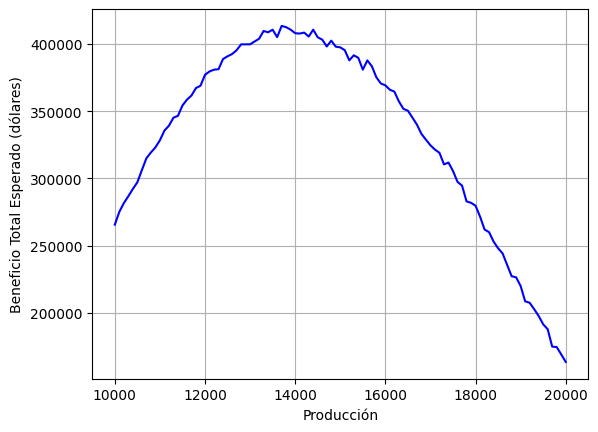

In [62]:
# Gráfica de beneficio total vs. cantidades de producción
plt.plot(df_resultados['Producción'], df_resultados['Beneficio Total Esperado (dólares)'], color='blue')
plt.xlabel('Producción')
plt.ylabel('Beneficio Total Esperado (dólares)')
plt.grid()
plt.show()

In [63]:
# Registramos la iteración con el mayor beneficio total esperado en esta réplica
replicas = pd.concat([replicas, df_resultados.loc[df_resultados['Beneficio Total Esperado (dólares)'] == df_resultados['Beneficio Total Esperado (dólares)'].max()]])
replicas

,Producción,Beneficio Total Esperado (dólares)
44,14400,"411,318.02"
42,14200,"412,124.66"
36,13600,"412,135.58"
41,14100,"409,456.10"
39,13900,"412,568.46"
38,13800,"412,191.16"
38,13800,"412,541.94"
42,14200,"409,885.14"
43,14300,"410,406.63"
37,13700,"413,395.19"


### Selección Final de Política de Producción

In [96]:
# Estadísticas de los resultados
print(replicas['Producción'].describe())

count       10.00
mean    14,000.00
std        274.87
min     13,600.00
25%     13,800.00
50%     14,000.00
75%     14,200.00
max     14,400.00
Name: Producción, dtype: float64


In [3]:
# Importamos el paquete estadístico en Python para el cálculo del intervalo de confianza y las pruebas de hipótesis
import scipy.stats as st

In [86]:
# Creamos una lista con los resultados de las réplicas
cantidades = replicas['Producción'].tolist()

In [72]:
# Cálculo del intervalo de confianza de 95% para las cantidades a producir. Dado que el tamaño de la muestra es menor a 30 datos, utilizamos la distribución T de Student
intervalo = st.t.interval(confidence = 0.95, df = len(cantidades) - 1, loc = 13900, scale = st.sem(cantidades))
print(intervalo)

(13807.956175933637, 13992.043824066363)


### Validación del Modelo

In [90]:
# Establecemos un nivel de significancia del 5%
alpha = 0.05

In [87]:
# Almacenamos en una lista los resultados de las réplicas registradas en el informe
cantidades = [13900, 13800, 13900, 14000, 14000, 13900, 14200, 13800, 13800, 13800]

In [67]:
# Almacenamos los valores reales suministrados por los quince vendedores para compararlos con los valores almacenados en la lista "cantidades" obtenidos de las 10 réplicas del experimento
cantidades_reales = [15000, 10000, 15000, 20000, 10000, 15000, 15000, 10000, 15000, 10000, 10000, 15000, 15000, 10000, 10000]

In [91]:
# Realizamos el ANOVA
estadistico_f, p_valor = st.f_oneway(cantidades_reales, cantidades)
print(f'Estadístico F: {estadistico_f}')
print(f'Valor p: {p_valor}')
p_valor < alpha

Estadístico F: 0.8154021791093765
Valor p: 0.37588839385029815


False

In [92]:
# Realizamos la prueba T para la media correspondiente a varianzas iguales y poblacionalmente desconocidas y con media poblacional desconocida
estadistico_t, p_valor = st.ttest_ind(cantidades_reales, cantidades, alternative='less')
print(f'Estadístico T: {estadistico_t}')
print(f'Valor p: {p_valor}')
p_valor < alpha

Estadístico T: -0.9029962231977365
Valor p: 0.1879441969251492


False